# VAE

In [1]:
!pip install elasticsearch
!pip install elasticsearch_dsl
!pip install pymed
!pip install gensim

     |████████████████████████████████| 188 kB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 3.8 MB/s  eta 0:00:01
     |████████████████████████████████| 24.2 MB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 75.3 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.1.0-py3-none-any.whl size=110317 sha256=313173dafdfa4c79b44b4fd88cc3dc84449633a3dbdd3329e1248b8e490ba2f5
  Stored in directory: /home/ubuntu/.cache/pip/wheels/a4/9b/d5/85705a7ab783cd6f7bd718f01d3b1396272f30044e3c36401a
Successfully built smart-open


In [53]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import utils
import os
from utils import PROJECT_ROOT, DATA_PATH
import yuval_module.paper_source as PaperSource

import py_4.get_mesh_vec as get_mesh_vec
import py_3.sim_matrix_3 as sim_matrix_3
import py_4.get_all_features as get_all_features 

from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
#settings

batch_size= 8
epochs = 2
cuda = torch.cuda.is_available()
seed = 42
log_interval = 5
num_workers = 2

#check for cuda
device = torch.device('cuda' if cuda else 'cpu')

torch.manual_seed(seed)
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

device

device(type='cpu')

In [8]:
mesh_embed=get_mesh_vec.MeshEmbeddings("/home/ubuntu/AYP/data/mesh_data/MeSHFeatureGeneratedByDeepWalk.csv")

In [10]:
FILE = "enriched_labeled_dataset_large" 
if os.path.exists(PROJECT_ROOT + DATA_PATH + FILE):
    print("READING FROM LOCAL")
    if FILE.split(".")[1] == "json":
        df = pd.read_json(PROJECT_ROOT + DATA_PATH + FILE)
    else:
        df = pd.read_csv(PROJECT_ROOT + DATA_PATH + FILE)
    #ps = PaperSource()
else:
    print("PULLING FROM S3")
    ps = sim_matrix_3.load_dataset(FILE)
    df = ps.get_dataset()

df.drop(columns=["last_author_country"],inplace=True)
df.rename(columns={'ORG_STATE':'last_author_country'},inplace=True)

print("FILE PULLED")

PULLING FROM S3
FILE PULLED


### TOY DATASET RUN ###

In [182]:
auth_core, auth_eps, auth_usecase = sim_matrix_3.split_authors(pd,df)

#Take five authors from base case
df_core = df[df['last_author_name'].isin(auth_core[:5])]

187
94


In [296]:
selection = auth_core[:15]

In [343]:
class ToyDS(Dataset):
    def __init__(self,df,selection,vae_features = None):
        super().__init__()
        self.df = df[df['last_author_name'].isin(selection)]
        if vae_features is None:
            self.vae_features = get_all_features.VAE_Features(self.df)
        else:
            self.vae_features = vae_features
        self.features = self.vae_features.get_all_features(self.df)
        print(list(self.vae_features.mesh_features.mesh_missing))
        self.input_dim = self.vae_features.input_dims
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        features = self.features[idx]
        return features
    
    def __getvae__(self):
        return self.vae_features

In [345]:
train_set = ToyDS(df, selection)
train_loader=DataLoader(dataset= train_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

['MESH NAME NOT FOUND: Female', 'MESH NAME NOT FOUND: Male']


In [346]:
class VAE(nn.Module):
    def __init__(self, input_dim = train_set.input_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(self.input_dim, 32)
        self.fc21 = nn.Linear(32, 8)
        self.fc22 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 32)
        self.fc4 = nn.Linear(32, self.input_dim)
        
        #Want to initialize logvar weights to 0
#         self.fc22.weight.data.fill_(0)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

In [347]:
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64), reduction='sum')

    MSE = F.mse_loss(recon_x, x.view(-1, train_set.input_dim))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

In [348]:
log_interval = 10

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [349]:
from torchsummary import summary
summary(model, (20,train_set.input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           2,112
            Linear-2                    [-1, 8]             264
            Linear-3                    [-1, 8]             264
            Linear-4                   [-1, 32]             288
            Linear-5                   [-1, 65]           2,145
Total params: 5,073
Trainable params: 5,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [350]:
def train_epoch(tr_loader, model, criterion, optimizer, num_epochs):
    model.train()
    train_log = []
    
    for epoch in range(num_epochs):
        bottle_neck=[]
        print("Started training epoch no. {}".format(epoch+1))
        train_loss= 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            recon_batch, mu, logvar, z = model(data)
            bottle_neck.extend(z.detach().numpy())
            loss = criterion(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}\n'.format(
            epoch, train_loss / len(train_loader.dataset)))
        train_log.append({
            'epoch': epoch,
            'train_loss': train_loss / len(train_loader)})
    return train_log, bottle_neck

In [351]:
# def test(epoch):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

In [352]:
train_log, bottle_neck= train_epoch(train_loader,model,loss_function,optimizer,num_epochs= 3)

Started training epoch no. 1
Train Epoch: 0 [0/295 (0%)]	Loss: 6.381289
Train Epoch: 0 [80/295 (27%)]	Loss: 2.904912
Train Epoch: 0 [160/295 (54%)]	Loss: 1.197813
Train Epoch: 0 [240/295 (81%)]	Loss: 2.971949
====> Epoch: 0 Average loss: 2.4626

Started training epoch no. 2
Train Epoch: 1 [0/295 (0%)]	Loss: 1.355338
Train Epoch: 1 [80/295 (27%)]	Loss: 1.403716
Train Epoch: 1 [160/295 (54%)]	Loss: 2.040296
Train Epoch: 1 [240/295 (81%)]	Loss: 1.289804
====> Epoch: 1 Average loss: 1.6675

Started training epoch no. 3
Train Epoch: 2 [0/295 (0%)]	Loss: 1.296019
Train Epoch: 2 [80/295 (27%)]	Loss: 1.451575
Train Epoch: 2 [160/295 (54%)]	Loss: 1.662232
Train Epoch: 2 [240/295 (81%)]	Loss: 1.579229
====> Epoch: 2 Average loss: 1.5610



In [165]:
len(bottle_neck)

72

# Test

In [92]:
test_set = ToyDS(df[df.PI_IDS.isin(selection)])
test_loader=DataLoader(dataset= test_set, batch_size = batch_size, shuffle = True, num_workers = num_workers)

MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Female
MESH NAME NOT FOUND: Male
MESH NAME NOT FOUND: Male
MESH NAME 

In [93]:
bottle_neck=[]
for batch_idx, (data, _) in enumerate(test_loader):
            data = data.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            recon_batch, mu, logvar, z= model(data)
            bottle_neck.extend(z.detach().numpy())

In [94]:
bottle_neck

[array([-0.6486725 , -0.15034525, -1.0171756 , -0.16950682, -0.22891621,
        -3.270538  , -0.28580105, -0.3674364 ], dtype=float32),
 array([ 0.8835745 , -0.03101728, -0.5089596 , -2.1510155 ,  1.1890123 ,
        -1.3621026 , -0.34572008, -0.83343077], dtype=float32),
 array([-1.1953305 , -0.27174437, -1.4440532 , -0.3045028 ,  1.2823002 ,
        -1.3462763 , -1.3165208 , -0.86988634], dtype=float32),
 array([ 1.7830164 , -0.96988785, -0.9716988 , -1.399534  ,  0.5548248 ,
        -0.45105729, -0.01939731,  0.5986611 ], dtype=float32),
 array([-0.8280789 ,  0.26614776, -0.89590377,  0.8540143 , -0.9096126 ,
        -1.7499075 ,  0.45291007, -0.12698995], dtype=float32),
 array([-0.02145121,  1.1948818 ,  1.2952127 , -1.0339434 , -0.517646  ,
         1.4353939 , -0.656565  ,  0.2335705 ], dtype=float32),
 array([ 0.7585333 ,  0.45156795,  1.1655523 ,  0.32099745,  1.328476  ,
        -0.7823271 ,  0.98038334, -0.4957803 ], dtype=float32),
 array([-0.7761407 , -3.0280778 ,  0.7230

In [95]:
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time


In [102]:
ds=np.array(bottle_neck)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=1, n_iter=300)
tsne_results = tsne.fit_transform(ds)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 72 samples in 0.000s...
[t-SNE] Computed neighbors for 72 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 72 / 72
[t-SNE] Mean sigma: 0.229830
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.891182
[t-SNE] KL divergence after 300 iterations: 2.995824
t-SNE done! Time elapsed: 0.09877514839172363 seconds


In [103]:
df_subset=pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['PI'] = PI_lst

Text(0, 0.5, 'tsne-2d-one')

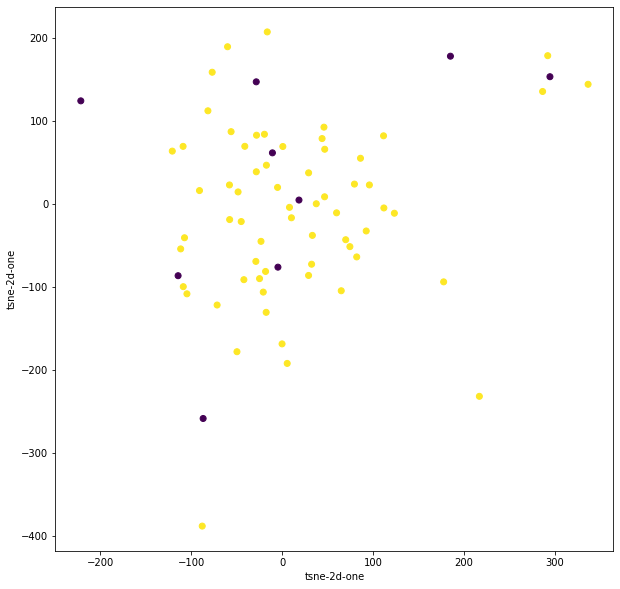

In [104]:
plt.figure(figsize=(10,10))
plt.scatter(df_subset['tsne-2d-one'],df_subset['tsne-2d-two'],c=df_subset['PI'])
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-one')


In [40]:
tsne_results

array([[-2.2443347 , -4.706242  ],
       [ 4.034638  ,  2.8211336 ],
       [ 1.2392521 , -1.8968908 ],
       ...,
       [-5.816544  , -8.111503  ],
       [-0.77172625, -2.0545878 ],
       [-0.9246067 , -5.730704  ]], dtype=float32)